In [1]:
import numpy as np
from time import perf_counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

sns.set(font_scale=0.7)

# Cube

In [2]:
from enum import Enum

class TargetState(Enum):
    SEQUENTIAL = [
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 9],
    ]
    IDENTITY = [
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
    ]
    HORIZONTAL = [
        [1, 1, 1],
        [2, 2, 2],
        [3, 3, 3],
    ]
    FIVESEQUENTIAL = [
        [ 1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10],
        [11, 12, 13, 14, 15],
        [16, 17, 18, 19, 20],
        [21, 22, 23, 24, 25],
    ]
    

class Cube:
    
    def __init__(self, target_state): 
        self.target_state = np.array(target_state.value)
        self.arr = np.array(target_state.value)

    def is_solved(self):
        return np.array_equal(self.arr, self.target_state)

    def shuffle(self):
        self.arr = self.arr.flatten()
        np.random.shuffle(self.arr)
        self.arr = self.arr.reshape(self.target_state.shape)

    def swap(self, ax, ay, bx, by):
        self.arr[(ax, ay)], self.arr[(bx, by)] = self.arr[(bx, by)], self.arr[(ax, ay)]

    def show(self):
        plt.figure(figsize=(len(self.arr) / 2, len(self.arr) / 2))
        sns.heatmap(self.arr, cbar=False, xticklabels=False, yticklabels=False,
                    linewidth=0.5, annot=True, cmap='coolwarm', square=True)
        plt.show()

    def __repr__(self):
        return str(self.arr)

# Solvers

In [3]:
class ABCSolver(ABC):
    
    def __init__(self, cube):
        self.cube = cube
        self.counter = None
        self.timer = None

    def solve(self, verbose=False):
        self.counter = 0
        self.timer = 0
        tic = perf_counter()
        while not self.cube.is_solved():
            self.cube.swap(*self.next_best_move())
            self.counter += 1
            if verbose:
                self.cube.show()
        toc = perf_counter()
        self.timer = toc - tic

    @abstractmethod
    def next_best_move(self):
        pass

    def __repr__(self):
        return str(self.__class__.__name__)
        

class RandomSolver(ABCSolver):
    def next_best_move(self):
        return np.random.randint(0, 3, 4)


class TargetedRandomSolver(ABCSolver):
    def next_best_move(self):
        idx = np.argwhere(self.cube.arr != self.cube.target_state)
        return idx[np.random.choice(len(idx), size=2, replace=False)].flatten()

# Experiment (Simumlation)

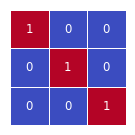

solver            RandomSolver  TargetedRandomSolver
simulations sum    1000.000000           1000.000000
counter     mean    196.971000              2.537000
            max    1367.000000             14.000000
timer       sum      10.322992              0.234633

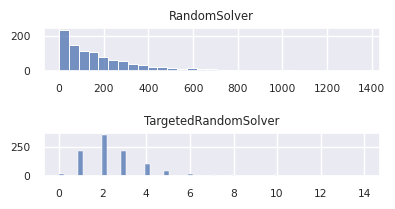

In [4]:
# Editiable parameters
n = 1_000
target_state = TargetState.IDENTITY
solvers = [RandomSolver, TargetedRandomSolver]

# Initalise cube
cube = Cube(target_state)
cube.show()

# Perform simulation
results = []
for s in solvers:
    solver = s(cube)
    for i in range(n):
        solver.cube.shuffle()
        solver.solve()
        results.append((str(solver), solver.counter, solver.timer))
df = pd.DataFrame(data=results, columns=['solver', 'counter' ,'timer'])

# Show simulation summary stats
display(
    df
    .assign(simulations=1)
    .groupby('solver')
    .agg({'simulations': ['sum'], 'counter': ['mean', 'max'], 'timer': ['sum']})
    .T
)

# Show simulation charts
fig, ax = plt.subplots(nrows=len(solvers), figsize=(4, len(solvers)))
plt.tight_layout(h_pad=3)
for i, solver_name in enumerate(np.unique(df.solver)):
    sns.histplot(
        data=df.loc[df.solver == solver_name, 'counter'],
        ax=ax[i]
    ).set_title(solver_name)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
plt.show()